In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['Id']
        self.all_labels = np.array(self.csv.drop(['Id', 'Genre'], axis=1))
        self.train_ratio = int(0.75 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-300])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-300:])
            self.labels = list(self.all_labels[-300:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"/content/drive/MyDrive/DL_dataset/Multi_Label_dataset/Images/{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [ ]:
from torchvision import models as models
import torch.nn as nn
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.fc = nn.Linear(2048, 25)
    return model

In [ ]:
def pred_acc(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

In [ ]:
import torch
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_acc=0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        acc_=[]
        for i1,d1 in enumerate(outputs, 0):
          acc=pred_acc(torch.Tensor.cpu(target[i1]), torch.Tensor.cpu(d1))
          acc_.append(acc)
        loss = criterion(outputs, target)
        train_running_acc+=(np.asarray(acc_).mean())
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
    train_acc=train_running_acc / counter   
    train_loss = train_running_loss / counter
    return train_loss, train_acc

In [ ]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_acc=0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            acc_=[]
            for i1,d1 in enumerate(outputs, 0):
              acc=pred_acc(torch.Tensor.cpu(target[i1]), torch.Tensor.cpu(d1))
              acc_.append(acc)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            val_running_acc+=(np.asarray(acc_).mean())
        val_acc=val_running_acc / counter
        val_loss = val_running_loss / counter
        return val_loss, val_acc

In [ ]:
# from . import models
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# from engine import train, validate
# from dataset import ImageDataset
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
model =model(pretrained=True, requires_grad=False).to(device)
# learning parameters
lr = 0.0001
epochs = 20
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
%cd '/content/drive/MyDrive/DL_dataset'

/content/drive/MyDrive/DL_dataset


In [ ]:
!ls

movie_posters.zip  Multi_Label_dataset


In [ ]:
img_zip_path ='/content/drive/MyDrive/DL_dataset/movie_posters.zip' 

In [ ]:
import os
import zipfile
import pandas as pd

In [ ]:
# zip_ref = zipfile.ZipFile(img_zip_path, 'r')
# zip_ref.extractall()
# zip_ref.close()

In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/DL_dataset/Multi_Label_dataset/train.csv')
# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 5440
Number of validation images: 1814


In [ ]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f} , Train acc: {train_epoch_acc:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f} , Valid acc: {valid_epoch_acc:.4f}')

Epoch 1 of 20
Training


100%|██████████| 170/170 [48:14<00:00, 17.03s/it]


Validating


48it [13:10, 16.47s/it]


Train Loss: 0.2736 , Train acc: 0.9023
Val Loss: 0.2428 , Valid acc: 0.9143
Epoch 2 of 20
Training


100%|██████████| 170/170 [03:26<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2346 , Train acc: 0.9154
Val Loss: 0.2386 , Valid acc: 0.9166
Epoch 3 of 20
Training


100%|██████████| 170/170 [03:26<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2284 , Train acc: 0.9175
Val Loss: 0.2334 , Valid acc: 0.9175
Epoch 4 of 20
Training


100%|██████████| 170/170 [03:26<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2241 , Train acc: 0.9182
Val Loss: 0.2284 , Valid acc: 0.9172
Epoch 5 of 20
Training


100%|██████████| 170/170 [03:26<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2205 , Train acc: 0.9184
Val Loss: 0.2258 , Valid acc: 0.9181
Epoch 6 of 20
Training


100%|██████████| 170/170 [03:26<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2183 , Train acc: 0.9187
Val Loss: 0.2239 , Valid acc: 0.9173
Epoch 7 of 20
Training


100%|██████████| 170/170 [03:26<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2156 , Train acc: 0.9193
Val Loss: 0.2243 , Valid acc: 0.9181
Epoch 8 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2140 , Train acc: 0.9196
Val Loss: 0.2221 , Valid acc: 0.9185
Epoch 9 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2127 , Train acc: 0.9198
Val Loss: 0.2219 , Valid acc: 0.9182
Epoch 10 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2116 , Train acc: 0.9197
Val Loss: 0.2207 , Valid acc: 0.9179
Epoch 11 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2101 , Train acc: 0.9203
Val Loss: 0.2211 , Valid acc: 0.9190
Epoch 12 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2090 , Train acc: 0.9202
Val Loss: 0.2180 , Valid acc: 0.9190
Epoch 13 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2082 , Train acc: 0.9203
Val Loss: 0.2181 , Valid acc: 0.9184
Epoch 14 of 20
Training


100%|██████████| 170/170 [03:26<00:00,  1.21s/it]


Validating


48it [00:54,  1.13s/it]


Train Loss: 0.2078 , Train acc: 0.9207
Val Loss: 0.2163 , Valid acc: 0.9190
Epoch 15 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.13s/it]


Train Loss: 0.2071 , Train acc: 0.9204
Val Loss: 0.2161 , Valid acc: 0.9189
Epoch 16 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2062 , Train acc: 0.9209
Val Loss: 0.2171 , Valid acc: 0.9191
Epoch 17 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2054 , Train acc: 0.9218
Val Loss: 0.2173 , Valid acc: 0.9189
Epoch 18 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2050 , Train acc: 0.9213
Val Loss: 0.2176 , Valid acc: 0.9189
Epoch 19 of 20
Training


100%|██████████| 170/170 [03:25<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]


Train Loss: 0.2045 , Train acc: 0.9214
Val Loss: 0.2143 , Valid acc: 0.9199
Epoch 20 of 20
Training


100%|██████████| 170/170 [03:26<00:00,  1.21s/it]


Validating


48it [00:54,  1.14s/it]

Train Loss: 0.2044 , Train acc: 0.9215
Val Loss: 0.2162 , Valid acc: 0.9194


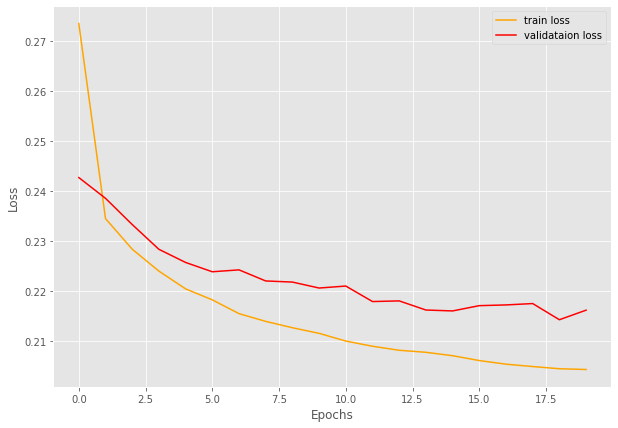

In [ ]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '/content/drive/MyDrive/DL_dataset/model.pth')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/DL_dataset/loss.png')
plt.show()

Testing the data

In [ ]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
from torchvision import models as models
import torch.nn as nn
def model2(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.fc = nn.Linear(2048, 25)
    return model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#intialize the model
model = model2(pretrained=False, requires_grad=False).to(device)
# load the model checkpoint
checkpoint = torch.load('/content/drive/MyDrive/DL_dataset/model.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/DL_dataset/Multi_Label_dataset/train.csv')
genres = train_csv.columns.values[2:]
# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv, train=False, test=True
)
test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=False
)

In [ ]:
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

In [ ]:
len(test_data)

300

In [ ]:
for counter, data in enumerate(test_loader):
    image, target = data['image'].to(device), data['label']
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-3:]
    string_predicted = ''
    string_actual = ''
    for i in range(len(best)):
        string_predicted += f"{genres[best[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{genres[target_indices[i]]}    "
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
    plt.savefig(f"/content/drive/MyDrive/DL_dataset/outputs/inference_{counter}.jpg")
    plt.show()

In [ ]:
count=0
acc_=[]
for counter, data in enumerate(test_loader):
  count+=1
  data, target = data['image'].to(device), data['label'].to(device)
  outputs = model(data)
  # apply sigmoid activation to get all the outputs between 0 and 1
  outputs = torch.sigmoid(outputs)
  for i1,d1 in enumerate(outputs, 0):
    acc=pred_acc(torch.Tensor.cpu(target[i1]), torch.Tensor.cpu(d1))
    acc_.append(acc)
    #print(acc)
print(sum(acc_) / count)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.9190666666666656
